# Task

## Loading and Inspecting Data

In [1]:
!pip install numpy==1.26.4

In [2]:
import pandas as pd
import re
import nltk
import numpy as np

from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [3]:
df = pd.read_csv('data.csv')

display(df.head())
display(df.info())
display(df.isnull().sum())

Age  Gender  EducationLevel  ExperienceYears  PreviousCompanies  \
0   26       1               2                0                  3   
1   39       1               4               12                  3   
2   48       0               2                3                  2   
3   34       1               2                5                  2   
4   30       0               1                6                  1   

   DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
0            26.783828              48          78                91   
1            25.862694              35          68                80   
2             9.920805              20          67                13   
3             6.407751              36          27                70   
4            43.105343              23          52                85   

   RecruitmentStrategy  HiringDecision  
0                    1               1  
1                    2               1  
2                    2               0  
3                    3               0  
4                    2               0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


None

Age                    0
Gender                 0
EducationLevel         0
ExperienceYears        0
PreviousCompanies      0
DistanceFromCompany    0
InterviewScore         0
SkillScore             0
PersonalityScore       0
RecruitmentStrategy    0
HiringDecision         0
dtype: int64

We assume male = 0, female = 1.

In [5]:
print(df['Gender'].value_counts())

Gender
0    762
1    738
Name: count, dtype: int64


In [4]:
print(df['EducationLevel'].value_counts())

EducationLevel
2    740
3    317
1    307
4    136
Name: count, dtype: int64


In [6]:
print(df['RecruitmentStrategy'].value_counts())

RecruitmentStrategy
2    770
1    445
3    285
Name: count, dtype: int64


In [7]:
print(df['HiringDecision'].value_counts())

HiringDecision
0    1035
1     465
Name: count, dtype: int64


In [8]:
df[(df['Gender'] == 1) & (df['HiringDecision'] == 1)].shape[0]

228

In [9]:
df[(df['Gender'] == 0) & (df['HiringDecision'] == 1)].shape[0]

237

Not a huge difference between female and male hires.


# Creating Resume Text from Data

In [10]:
def gender_text(gender):
    return "male " if gender == 0 else "female"

def education_text(level):
    return {
        1: "a Bachelor's degree (Type 1)",
        2: "a Bachelor's degree (Type 2)",
        3: "a Master's degree",
        4: "a PhD"
    }.get(level, "an unknown degree")

In [11]:
def generate_resume(row):
    return (
        f"I am a {gender_text(row['Gender'])} candidate, {int(row['Age'])} years old, "
        f"with {education_text(row['EducationLevel'])} and {row['ExperienceYears']} years of experience "
        f"across {row['PreviousCompanies']} companies. "
        f"I live {row['DistanceFromCompany']:.2f} km from the company. "
        f"I scored {row['InterviewScore']} in the interview, with a skill score of {row['SkillScore']} "
        f"and a personality score of {row['PersonalityScore']}. "
        f"I applied through Strategy {row['RecruitmentStrategy']}."
    )

In [12]:
df['Resume_Text'] = df.apply(generate_resume, axis=1)

In [13]:
print(df['Resume_Text'][0])

I am a female candidate, 26 years old, with a Bachelor's degree (Type 2) and 0.0 years of experience across 3.0 companies. I live 26.78 km from the company. I scored 48.0 in the interview, with a skill score of 78.0 and a personality score of 91.0. I applied through Strategy 1.0.


# Preparing Data & Creating Class Imbalance

In [14]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['HiringDecision'])

male_train = train_df[train_df['Gender'] == 0].sample(frac=1.0, random_state=42)
female_train = train_df[train_df['Gender'] == 1].sample(frac=0.3, random_state=42)

imbalanced_train_df = pd.concat([male_train, female_train]).sample(frac=1.0, random_state=42)

print("Training gender distribution:")
print(imbalanced_train_df['Gender'].value_counts(normalize=True))
print("\nTest gender distribution:")
print(test_df['Gender'].value_counts(normalize=True))

Training gender distribution:
Gender
0    0.779319
1    0.220681
Name: proportion, dtype: float64

Test gender distribution:
Gender
1    0.52
0    0.48
Name: proportion, dtype: float64


# Training BERT on classification task

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset.from_pandas(imbalanced_train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
train_ds = train_dataset.rename_column("HiringDecision", "label")
test_ds = test_dataset.rename_column("HiringDecision", "label")

In [ ]:
def tokenize(batch):
    return tokenizer(batch["Resume_Text"], padding="max_length", truncation=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
)

trainer.train()

TrainOutput(global_step=300, training_loss=0.44652127027511596, metrics={'train_runtime': 107.343, 'train_samples_per_second': 22.163, 'train_steps_per_second': 2.795, 'total_flos': 156485300175360.0, 'train_loss': 0.44652127027511596, 'epoch': 3.0})

In [ ]:
outputs = trainer.predict(test_ds)
y_pred = np.argmax(outputs.predictions, axis=1)
y_true = outputs.label_ids

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       207
           1       0.82      0.75      0.79        93

    accuracy                           0.87       300
   macro avg       0.86      0.84      0.85       300
weighted avg       0.87      0.87      0.87       300



# Calculating Fairness Metrics

Calculate demographic parity in gender as it is the only non-technical demographic we have. Defined as the difference between the average of predictions between groups.

In [ ]:
genders = np.array(test_ds["Gender"])

In [ ]:
def demographic_parity(y_pred, genders):
    return abs(y_pred[genders == 1].mean() - y_pred[genders == 0].mean())

In [ ]:
print("Demographic Parity:", demographic_parity(y_pred, genders))

Demographic Parity: 0.03739316239316237


This shows minimal difference in decisions based on gender.

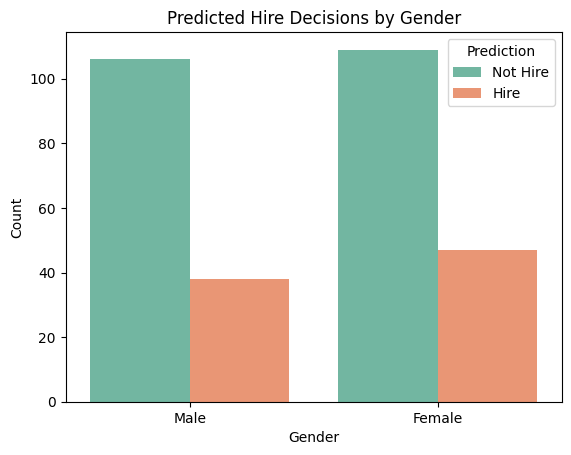

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_eval = pd.DataFrame({'Gender': genders, 'Prediction': y_pred})

sns.countplot(data=df_eval, x='Gender', hue='Prediction', palette='Set2')
plt.xticks([0, 1], ['Male', 'Female'])
plt.title("Predicted Hire Decisions by Gender")
plt.ylabel("Count")
plt.legend(title="Prediction", labels=['Not Hire', 'Hire'])
plt.show()

Further shown in the graph plotting disparity in predictions above as well.

For equal opportunity we calculate the difference in true positive rates, and in average odds, we get the average of the difference between true positive and false positive rates in the groups.

In [ ]:
def equal_opportunity(y_true, y_pred, genders):
    # getting true positive for female vs male
    tpr_f = ((y_pred == 1) & (y_true == 1) & (genders == 1)).sum() / ((y_true == 1) & (genders == 1)).sum()
    tpr_m = ((y_pred == 1) & (y_true == 1) & (genders == 0)).sum() / ((y_true == 1) & (genders == 0)).sum()
    return abs(tpr_f - tpr_m)

In [ ]:
print("Equal Opportunity:", equal_opportunity(y_true, y_pred, genders))

Equal Opportunity: 0.13632075471698113


In [ ]:
def average_odds_difference(y_true, y_pred, genders):
    # average of diff between true positive and false positive
    tpr_f = ((y_pred == 1) & (y_true == 1) & (genders == 1)).sum() / ((y_true == 1) & (genders == 1)).sum()
    tpr_m = ((y_pred == 1) & (y_true == 1) & (genders == 0)).sum() / ((y_true == 1) & (genders == 0)).sum()

    fpr_f = ((y_pred == 1) & (y_true == 0) & (genders == 1)).sum() / ((y_true == 0) & (genders == 1)).sum()
    fpr_m = ((y_pred == 1) & (y_true == 0) & (genders == 0)).sum() / ((y_true == 0) & (genders == 0)).sum()

    return 0.5 * (abs(tpr_f - tpr_m) + abs(fpr_f - fpr_m))

In [ ]:
print("Average Odds Difference:", average_odds_difference(y_true, y_pred, genders))

Average Odds Difference: 0.10162751701495061


# Using SHAP to explain decisions

In [ ]:
import shap
import torch

In [ ]:
def predict_proba(texts):
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif not isinstance(texts, list):
        raise ValueError("Input texts must be a string, list of strings, or numpy array of strings.")

    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

In [ ]:
test_df['Prediction'] = y_pred

In [ ]:
sample_hired = test_df[test_df['Prediction'] == 1].sample(3, random_state=19)
sample_not_hired = test_df[test_df['Prediction'] == 0].sample(2, random_state=19)

sample_texts = pd.concat([sample_hired, sample_not_hired])['Resume_Text'].tolist()

In [ ]:
sample_texts = [str(x).strip() for x in sample_texts]

In [ ]:
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_proba, masker)
shap_values = explainer(sample_texts)

PartitionExplainer explainer: 6it [00:14,  7.21s/it]


In [ ]:
for i, text in enumerate(sample_texts):
    print(f"\n--- Resume {i+1} ---")
    shap.plots.text(shap_values[i])


--- Resume 1 ---



--- Resume 2 ---



--- Resume 3 ---



--- Resume 4 ---



--- Resume 5 ---


In [ ]:
probs = predict_proba(sample_texts)  # shape: (n_samples, 2)

for i, text in enumerate(sample_texts):
    prob_hire = probs[i][1]  # class 1 = "Hire"
    decision = "HIRE" if prob_hire >= 0.5 else "NO HIRE"

    print(f"\n==================== Resume {i+1} ====================")
    print(f"Decision: {decision} (probability of hire: {prob_hire:.2f})\n")
    print("Top 10 Token Contributions:")

    tokens = shap_values[i].data
    shap_vals = shap_values[i].values

    # Flatten SHAP values
    clean_vals = []
    for val in shap_vals:
        if isinstance(val, (list, np.ndarray)):
            clean_vals.append(float(val[1]) if len(val) > 1 else float(val[0]))
        else:
            clean_vals.append(float(val))

    # Pair tokens with values and sort
    top_tokens = sorted(zip(tokens, clean_vals), key=lambda x: abs(x[1]), reverse=True)[:10]

    for token, val in top_tokens:
        print(f"{token:>15}  --->  {val:+.5f}")


==================== Resume 1 ====================
Decision: HIRE (probability of hire: 0.88)

Top 10 Token Contributions:
             82  --->  +0.12152
        through  --->  -0.01008
       strategy  --->  -0.01008
           type  --->  -0.00900
              )  --->  -0.00747
              2  --->  -0.00722
              (  --->  -0.00620
              1  --->  -0.00545
    personality  --->  -0.00530
              a  --->  -0.00421

==================== Resume 2 ====================
Decision: HIRE (probability of hire: 0.88)

Top 10 Token Contributions:
             93  --->  +0.05777
             55  --->  +0.01426
             of  --->  +0.00954
           type  --->  -0.00870
              )  --->  -0.00754
              .  --->  +0.00699
              2  --->  -0.00681
              (  --->  -0.00622
          score  --->  +0.00359
             of  --->  +0.00359

==================== Resume 3 ====================
Decision: HIRE (probability of hire: 0.74)

Top 10 Token Con

As we can see, gender had very little to do with the hiring decision.

# Counterfactual Data Augmentation

As it is our only demographic, we exchange the words 'female' with 'male' in the data and vice versa. We begin this step from the imbalanced training set (with more male than female resumes).

In [16]:
def swap_gender(text):
    if " male " in text:
        return text.replace(" male ", " female ")
    elif " female " in text:
        return text.replace(" female ", " male ")
    else:
        return text

In [17]:
counterfactual_df = imbalanced_train_df.copy()

counterfactual_df["Resume_Text"] = counterfactual_df["Resume_Text"].apply(swap_gender)
counterfactual_df["Gender"] = 1 - counterfactual_df["Gender"]

# concat original + counterfactual data
augmented_train_df = pd.concat([imbalanced_train_df, counterfactual_df]).sample(frac=1.0, random_state=42)

print("Original:", imbalanced_train_df.shape)
print("Counterfactual:", counterfactual_df.shape)
print("Augmented:", augmented_train_df.shape)

Original: (793, 12)
Counterfactual: (793, 12)
Augmented: (1586, 12)


We redo all our work from this point, from training BERT to doing SHAP.

In [18]:
train_dataset = Dataset.from_pandas(counterfactual_df)
test_dataset = Dataset.from_pandas(test_df)

In [19]:
train_ds = train_dataset.rename_column("HiringDecision", "label")
test_ds = test_dataset.rename_column("HiringDecision", "label")

In [20]:
def tokenize(batch):
    return tokenizer(batch["Resume_Text"], padding="max_length", truncation=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [21]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yoriis (yoriis-alexandria-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=300, training_loss=0.4804911144574483, metrics={'train_runtime': 168.0695, 'train_samples_per_second': 14.155, 'train_steps_per_second': 1.785, 'total_flos': 156485300175360.0, 'train_loss': 0.4804911144574483, 'epoch': 3.0})

In [23]:
outputs = trainer.predict(test_ds)
y_pred = np.argmax(outputs.predictions, axis=1)
y_true = outputs.label_ids

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       207
           1       0.71      0.72      0.72        93

    accuracy                           0.82       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.82      0.82      0.82       300



In [24]:
genders = np.array(test_ds["Gender"])

In [25]:
def demographic_parity(y_pred, genders):
    return abs(y_pred[genders == 1].mean() - y_pred[genders == 0].mean())

In [26]:
print("Demographic Parity:", demographic_parity(y_pred, genders))

Demographic Parity: 0.09508547008547008


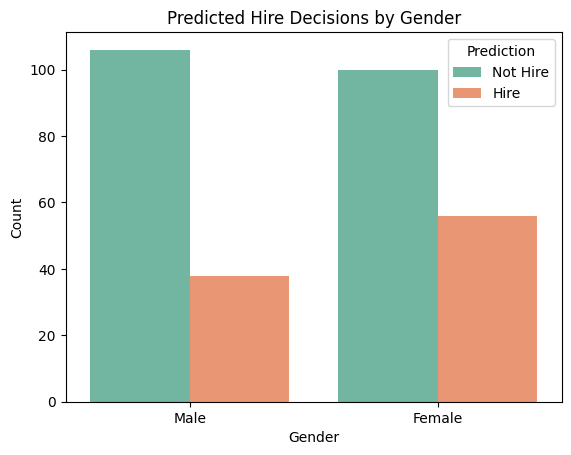

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
df_eval = pd.DataFrame({'Gender': genders, 'Prediction': y_pred})

sns.countplot(data=df_eval, x='Gender', hue='Prediction', palette='Set2')
plt.xticks([0, 1], ['Male', 'Female'])
plt.title("Predicted Hire Decisions by Gender")
plt.ylabel("Count")
plt.legend(title="Prediction", labels=['Not Hire', 'Hire'])
plt.show()

In [28]:
def equal_opportunity(y_true, y_pred, genders):
    # getting true positive for female vs male
    tpr_f = ((y_pred == 1) & (y_true == 1) & (genders == 1)).sum() / ((y_true == 1) & (genders == 1)).sum()
    tpr_m = ((y_pred == 1) & (y_true == 1) & (genders == 0)).sum() / ((y_true == 1) & (genders == 0)).sum()
    return abs(tpr_f - tpr_m)

In [29]:
print("Equal Opportunity:", equal_opportunity(y_true, y_pred, genders))

Equal Opportunity: 0.2113207547169812


In [30]:
def average_odds_difference(y_true, y_pred, genders):
    # average of diff between true positive and false positive
    tpr_f = ((y_pred == 1) & (y_true == 1) & (genders == 1)).sum() / ((y_true == 1) & (genders == 1)).sum()
    tpr_m = ((y_pred == 1) & (y_true == 1) & (genders == 0)).sum() / ((y_true == 1) & (genders == 0)).sum()

    fpr_f = ((y_pred == 1) & (y_true == 0) & (genders == 1)).sum() / ((y_true == 0) & (genders == 1)).sum()
    fpr_m = ((y_pred == 1) & (y_true == 0) & (genders == 0)).sum() / ((y_true == 0) & (genders == 0)).sum()

    return 0.5 * (abs(tpr_f - tpr_m) + abs(fpr_f - fpr_m))

In [31]:
print("Average Odds Difference:", average_odds_difference(y_true, y_pred, genders))

Average Odds Difference: 0.10986127354967805


In [32]:
test_df['Prediction'] = y_pred

In [33]:
sample_hired = test_df[test_df['Prediction'] == 1].sample(3, random_state=19)
sample_not_hired = test_df[test_df['Prediction'] == 0].sample(2, random_state=19)

sample_texts = pd.concat([sample_hired, sample_not_hired])['Resume_Text'].tolist()

In [34]:
sample_texts = [str(x).strip() for x in sample_texts]

In [41]:
import shap
import torch

In [43]:
def predict_proba(texts):
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif not isinstance(texts, list):
        raise ValueError("Input texts must be a string, list of strings, or numpy array of strings.")

    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

In [44]:
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_proba, masker)
shap_values = explainer(sample_texts)

PartitionExplainer explainer: 6it [00:19,  4.80s/it]


In [45]:
for i, text in enumerate(sample_texts):
    print(f"\n--- Resume {i+1} ---")
    shap.plots.text(shap_values[i])


--- Resume 1 ---



--- Resume 2 ---



--- Resume 3 ---



--- Resume 4 ---



--- Resume 5 ---


In [46]:
probs = predict_proba(sample_texts)  # shape: (n_samples, 2)

for i, text in enumerate(sample_texts):
    prob_hire = probs[i][1]  # class 1 = "Hire"
    decision = "HIRE" if prob_hire >= 0.5 else "NO HIRE"

    print(f"\n==================== Resume {i+1} ====================")
    print(f"Decision: {decision} (probability of hire: {prob_hire:.2f})\n")
    print("Top 10 Token Contributions:")

    tokens = shap_values[i].data
    shap_vals = shap_values[i].values

    # Flatten SHAP values
    clean_vals = []
    for val in shap_vals:
        if isinstance(val, (list, np.ndarray)):
            clean_vals.append(float(val[1]) if len(val) > 1 else float(val[0]))
        else:
            clean_vals.append(float(val))

    # Pair tokens with values and sort
    top_tokens = sorted(zip(tokens, clean_vals), key=lambda x: abs(x[1]), reverse=True)[:10]

    for token, val in top_tokens:
        print(f"{token:>15}  --->  {val:+.5f}")


==================== Resume 1 ====================
Decision: HIRE (probability of hire: 0.65)

Top 10 Token Contributions:
              1  --->  +0.08501
        through  --->  +0.07958
       strategy  --->  +0.07958
              2  --->  -0.07154
              0  --->  -0.04119
           type  --->  -0.03922
              0  --->  +0.02381
              .  --->  +0.01768
              .  --->  -0.01451
              .  --->  +0.01445

==================== Resume 2 ====================
Decision: HIRE (probability of hire: 0.67)

Top 10 Token Contributions:
              1  --->  +0.10141
        through  --->  +0.07893
       strategy  --->  +0.07893
              2  --->  -0.06007
              0  --->  -0.03776
           type  --->  -0.03521
              0  --->  +0.01922
              .  --->  -0.01637
              .  --->  +0.01613
              )  --->  +0.00935

==================== Resume 3 ====================
Decision: HIRE (probability of hire: 0.66)

Top 10 Token Con